In [52]:
import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt


In [53]:
def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

cwd = str(Path.cwd())
audio_datasets_main_dir_name = "01_audioDataset"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets.sort(key=sort_key_func)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise']


In [75]:
audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[0]
print(audio_dataset_dir)
#os.listdir(audio_dataset_dir)
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)
print(len(audio_files_sorted))
i = 0
while i < 5:
    print(audio_files_sorted[i])
    i += 1


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/01_Data/01_audioDataset/01_ethernet_without_additional_noise
60
New Recording 1.m4a
New Recording 2.m4a
New Recording 3.m4a
New Recording 4.m4a
New Recording 5.m4a


In [76]:
def next_power_of_2(x):
        next_power_of_two = 2**(math.ceil(math.log(x, 2)))

        if next_power_of_two == x:
            next_power_of_two = next_power_of_two*2

        return next_power_of_two

In [77]:
def power_to_db(S_mel, amin, top_db):
    
        S_dB = 10 * np.log10(np.maximum(S_mel, amin)) 
        #Sxx_dB -= 10 * np.log10(ref)
        # print(f" Sxx_dB max: {Sxx_dB.max()}")
        S_dB_clipped = np.maximum(S_dB, S_dB.max() - top_db)

        return S_dB_clipped

In [88]:
sampling_rate = 16000
resolution = 0.016
hop_length = int(resolution * sampling_rate)
n_fft =  next_power_of_2(hop_length)

audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[2])
print(audio_file_path)
signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)

print(f"signal shape: {signal.shape}")

n_samples = len(signal)
duration = n_samples / sampling_rate
time = np.linspace(0, duration, n_samples)

signal_stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=n_fft)
S = np.abs(signal_stft) ** 2
n_mels = 128
mel_filter_bank = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=n_mels, htk=True)
S_mel = np.dot(mel_filter_bank, S)

top_dB_abs = 100
dB_ref = 1e-12
S_dB = power_to_db(S_mel, amin=dB_ref, top_db=top_dB_abs)

print(f" S_dB shape: {S_dB.shape}")


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/01_Data/01_audioDataset/01_ethernet_without_additional_noise/New Recording 3.m4a
signal shape: (389782,)
 S_dB shape: (128, 1523)


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_14724/2666504457.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)


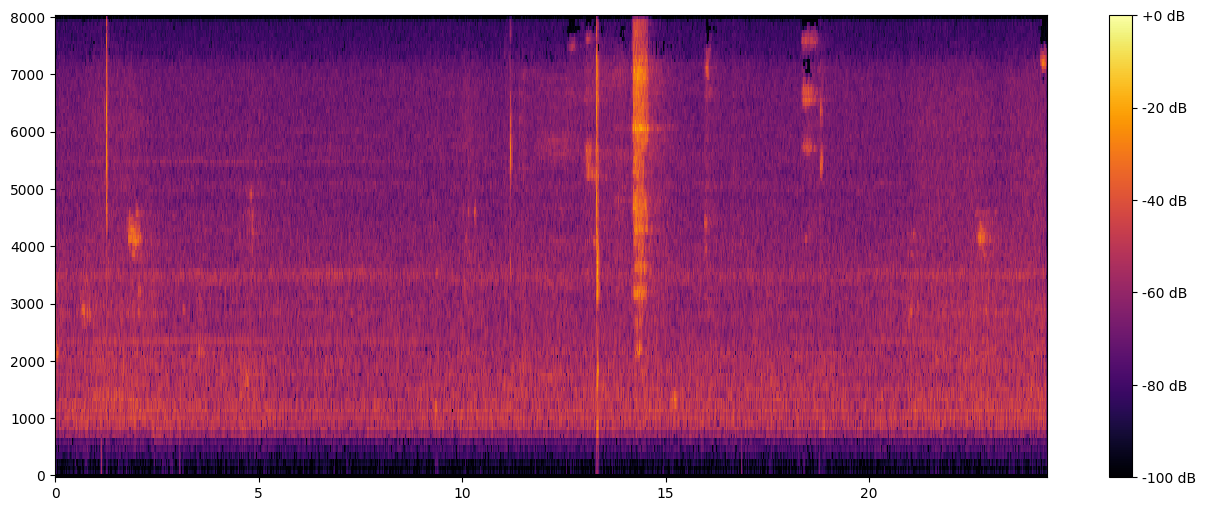

In [89]:
fig_x = 16
fig_y = 6
fig, ax = plt.subplots(1, 1, figsize=(fig_x, fig_y))

mel_spec_img = ax.pcolormesh(np.linspace(0, signal.shape[0] / sampling_rate, S_dB.shape[1]),
                                            np.linspace(0, sampling_rate // 2, n_mels), 
                                            S_dB, shading='auto', cmap='inferno')

mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=dB_ref)

colorbar = fig.colorbar(mel_spec_img, ax=ax, format="%+2.0f dB")

plt.show()